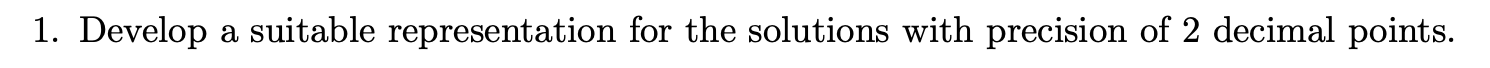

In [35]:
import numpy as np

Kp_range = (2, 18)
Ti_range = (1.05, 9.42)
Td_range = (0.26, 2.37)

def random_individual():
    return np.array(
        [
            round(np.random.uniform(*Kp_range), 2),
            round(np.random.uniform(*Ti_range), 2),
            round(np.random.uniform(*Td_range), 2)
        ])
individual = random_individual()
print(individual)

[14.69  7.56  1.73]


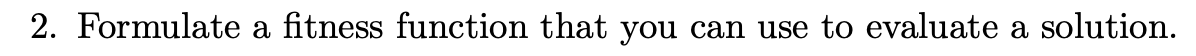

In [76]:
import control as ctrl

def is_stable(system):
    poles = ctrl.pole(system)
    return np.all(np.real(poles) < 0)

def compute_step_metrics(t, y):
    y_final = y[-1]
    y_10 = y_final * 0.1
    y_90 = y_final * 0.9

    # Rise time
    try:
        idx_10 = np.where(y >= y_10)[0][0]
        idx_90 = np.where(y >= y_90)[0][0]
        t_r = t[idx_90] - t[idx_10]
    except IndexError:
        t_r = float('inf')

    # Settling time (2% criterion)
    within_2_percent = np.abs(y - y_final) <= 0.02 * y_final
    if np.any(within_2_percent):
        t_s_candidates = t[within_2_percent]
        t_s = t_s_candidates[0]
    else:
        t_s = float('inf')

    # Overshoot
    M_p = (np.max(y) - y_final) / y_final * 100 if y_final != 0 else float('inf')

    return t_r, t_s, M_p

def performance_metrics(Kp, Ti, Td):
    G = Kp * ctrl.TransferFunction([Ti * Td, Ti, 1], [Ti, 0])
    F = ctrl.TransferFunction([1], [1, 6, 11, 6, 0])
    sys = ctrl.feedback(ctrl.series(G, F), 1)
    
    # Check if the system is stable
    if not is_stable(sys):
        # Return a high penalty if the system is unstable
        return float('inf'), float('inf'), float('inf'), float('inf')
    
    t = np.linspace(0, 20, num=2001)
    t, y = ctrl.step_response(sys, t)
    
    # Calculate performance metrics
    ISE = np.sum((y - 1)**2)
    t_r, t_s, M_p = compute_step_metrics(t, y)
    
    # Handle NaN values by returning a high penalty
    if np.isnan(ISE) or np.isnan(t_r) or np.isnan(t_s) or np.isnan(M_p):
        return float('inf'), float('inf'), float('inf'), float('inf')
    
    return ISE, t_r, t_s, M_p


In [26]:
def fitness_function(individual):
    ISE, t_r, t_s, M_p = performance_metrics(*individual)
    return ISE + t_r + t_s + M_p 

In [87]:
fitness_function(random_individual())


181.6316097165129

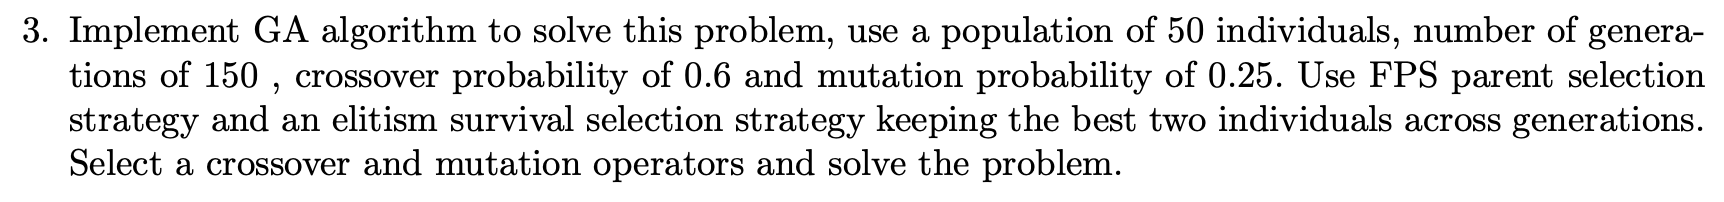

In [83]:
# Define GA parameters
population_size = 50
num_generations = 150
crossover_prob = 0.6
mutation_prob = 0.25
def initialize_population(population_size):
    i = 0
    population = []
    fitnesses = []
    while i < population_size:
        individual = random_individual()
        fitness = fitness_function(individual)

        # Unstable solutions break the algoirthm, so we ignore them
        if not np.isinf(fitness):
            population.append(individual)
            fitnesses.append(fitness)
            i += 1
    population = np.array(population)
    fitnesses = np.array(fitnesses)
    return population, fitnesses

In [84]:
print(initialize_population(2))

(array([[5.33, 3.09, 2.  ],
       [3.85, 8.35, 0.39]]), array([136.65282165, 276.72976659]))


In [47]:
def select_parents(population, selection_probs):
    parents_idx = np.random.choice(population_size, size=2, p=selection_probs)
    return population[parents_idx[0]], population[parents_idx[1]]

def crossover(parent1, parent2):
    if np.random.random() < crossover_prob:
        # Single point crossover
        crossover_point = np.random.randint(1, 3)
        child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
        return child1, child2
    return parent1, parent2

def mutate(individual):
    if np.random.random() < mutation_prob:
        # Guassian mutation
        individual[0] = round(np.clip(individual[0] + np.random.normal(0, 1), *Kp_range), 2)
        individual[1] = round(np.clip(individual[1] + np.random.normal(0, 1), *Ti_range), 2)
        individual[2] = round(np.clip(individual[2] + np.random.normal(0, 1), *Td_range), 2)
    return individual

In [ ]:
from multiprocessing import Pool

def compute_fitnesses(population):
    with Pool() as pool:
        fitnesses = pool.map(fitness_function, [individual for individual in population])
    return np.array(fitnesses)

In [93]:
def genetic_algorithm(population_size, num_generations):
    population, fitnesses = initialize_population(population_size)
    # print(population)?
    best_fitness_per_generation = []
    
    for generation in range(num_generations):
        print(f'Generation {generation + 1}/{num_generations}')
        if generation > 0:
            fitnesses = np.array([fitness_function(individual) for individual in population])

        best_fitness = min(fitnesses)
        best_fitness_per_generation.append(best_fitness)
        
        # Elitism: Keep the best two individuals
        sorted_indices = np.argsort(fitnesses)
        next_population = population[sorted_indices[:2]]
        next_fitnesses = fitnesses[sorted_indices[:2]]

        # Generate new offspring
        selection_probs = fitnesses / np.sum(fitnesses)
        while len(next_population) < population_size:
            parent1, parent2 = select_parents(population, selection_probs)
            child1, child2 = crossover(parent1, parent2)
    
            child1 = mutate(child1)
            child2 = mutate(child2)

            fitness1 = fitness_function(child1)
            fitness2 = fitness_function(child2)

            # Unstable solutions break the algorithm, so we ignore them
            if not np.isinf(fitness1):
                next_population = np.vstack([next_population, child1])
                next_fitnesses = np.append(next_fitnesses, fitness1)
            if not np.isinf(fitness2):
                next_population = np.vstack([next_population, child2])
                next_fitnesses = np.append(next_fitnesses, fitness2)
        
        population = next_population[:population_size]
    
    best_individual = population[sorted_indices[0]]
    return best_individual, best_fitness_per_generation

In [94]:
population_size = 50
num_generations = 150
crossover_prob = 0.6
mutation_prob = 0.25
best_individual, best_fitness_per_generation = genetic_algorithm(50, 5)

Generation 1/5
Generation 2/5
Generation 3/5
Generation 4/5
Generation 5/5


In [43]:
import matplotlib.pyplot as plt

def plot_results(best_fitness_per_generation):
    plt.plot(best_fitness_per_generation)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("GA Optimization Progress")
    plt.show()

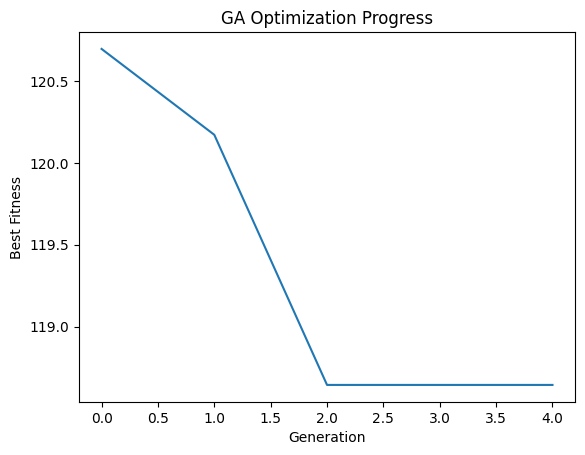

In [95]:
plot_results(best_fitness_per_generation)

### Too Slow
* The algorithm appears to be working but it is really slow, so I moved the code over to q1.py so I could use Pool() and also let it run in seperate terminal session in the background
* In addition to using Pool() for multiprocess fitness evaluation, I also made the following changes to try and increase speed:
    * Reduced the simulation time and datapoints
    * Compute step metrics manually

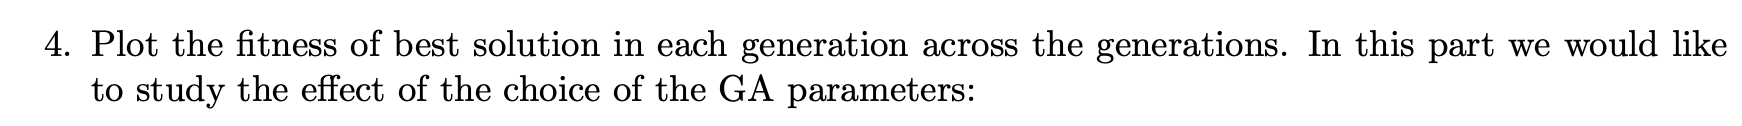

### 1.3 Output

#### Run Data

* Time taken: 1249.09s
* Best Individual: Kp=4.48 Ti=9.42 Td=2.37
* Best Fitness: 8.85

#### Plot
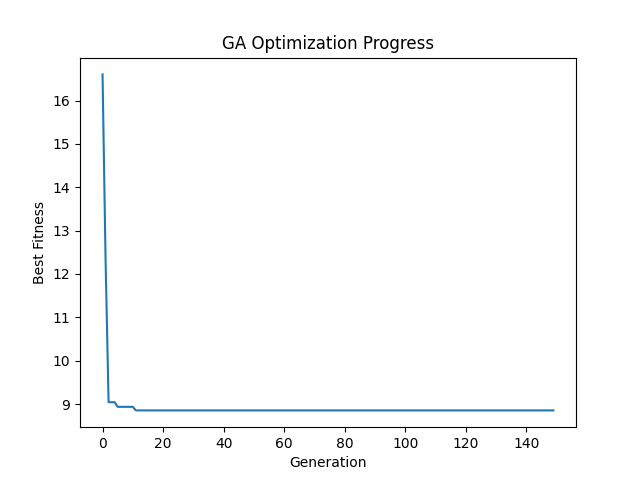

#### Summary of Results
* It looks like the algorithm converged pretty quickly onto a solution.
* This might mean that some of my hyper parameters are not well optimized or that my fitness function is not nuanced enough.
* It will be interesting to see what the result of the other experiments are.

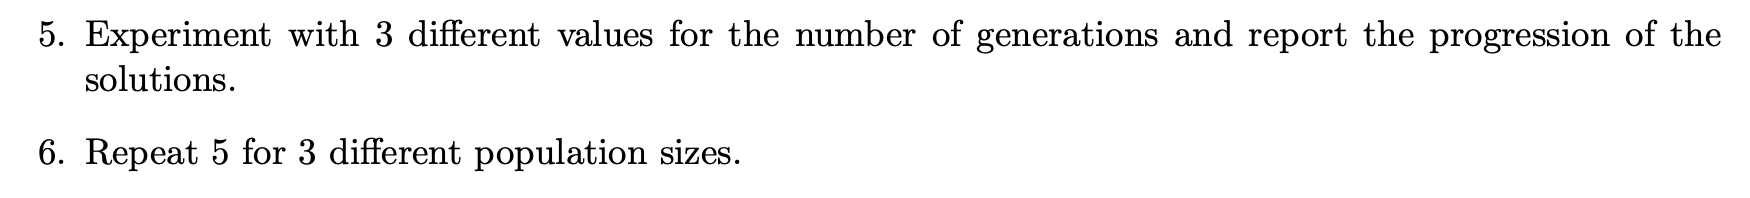

### Output for 1.5 and 1.6 Experiments
* Code for the experiemnts can be found in q1_5_6.py

#### Run Data (Running on M2 Macbook Air)
| Population Size | Number of Generations | Time Taken (s)       | Best [Kp, Ti, Td]      | Best Fitness         |
|-----------------|-----------------------|-----------------------|----------------------|-----------------------|
| 5               | 5                     | 8.67                 | [3.36, 6.67, 1.62]   | 22.601874254491094    |
| 20              | 5                     | 14.97                | [5.24, 6.64, 2.24]   | 17.5968793326458      |
| 50              | 5                     | 58.86                | [4.57, 8.25, 2.37]   | 10.438602377014647    |
| 5               | 20                    | 149.92               | [4.05, 9.41, 2.37]   | 9.586315498044097     |
| 20              | 20                    | 182.91               | [4.44, 9.42, 2.37]   | 8.919020023876456     |
| 50              | 20                    | 122.34               | [4.43, 9.42, 2.37]   | 8.935519614910277     |
| 5               | 50                    | 132.60               | [4.57, 8.67, 2.37]   | 10.065181185393772    |
| 20              | 50                    | 188.44               | [4.49, 9.42, 2.37]   | 8.856828765685307     |
| 50              | 50                    | 309.89               | [4.46, 9.42, 2.37]   | 8.886078598024888     |


#### Plots
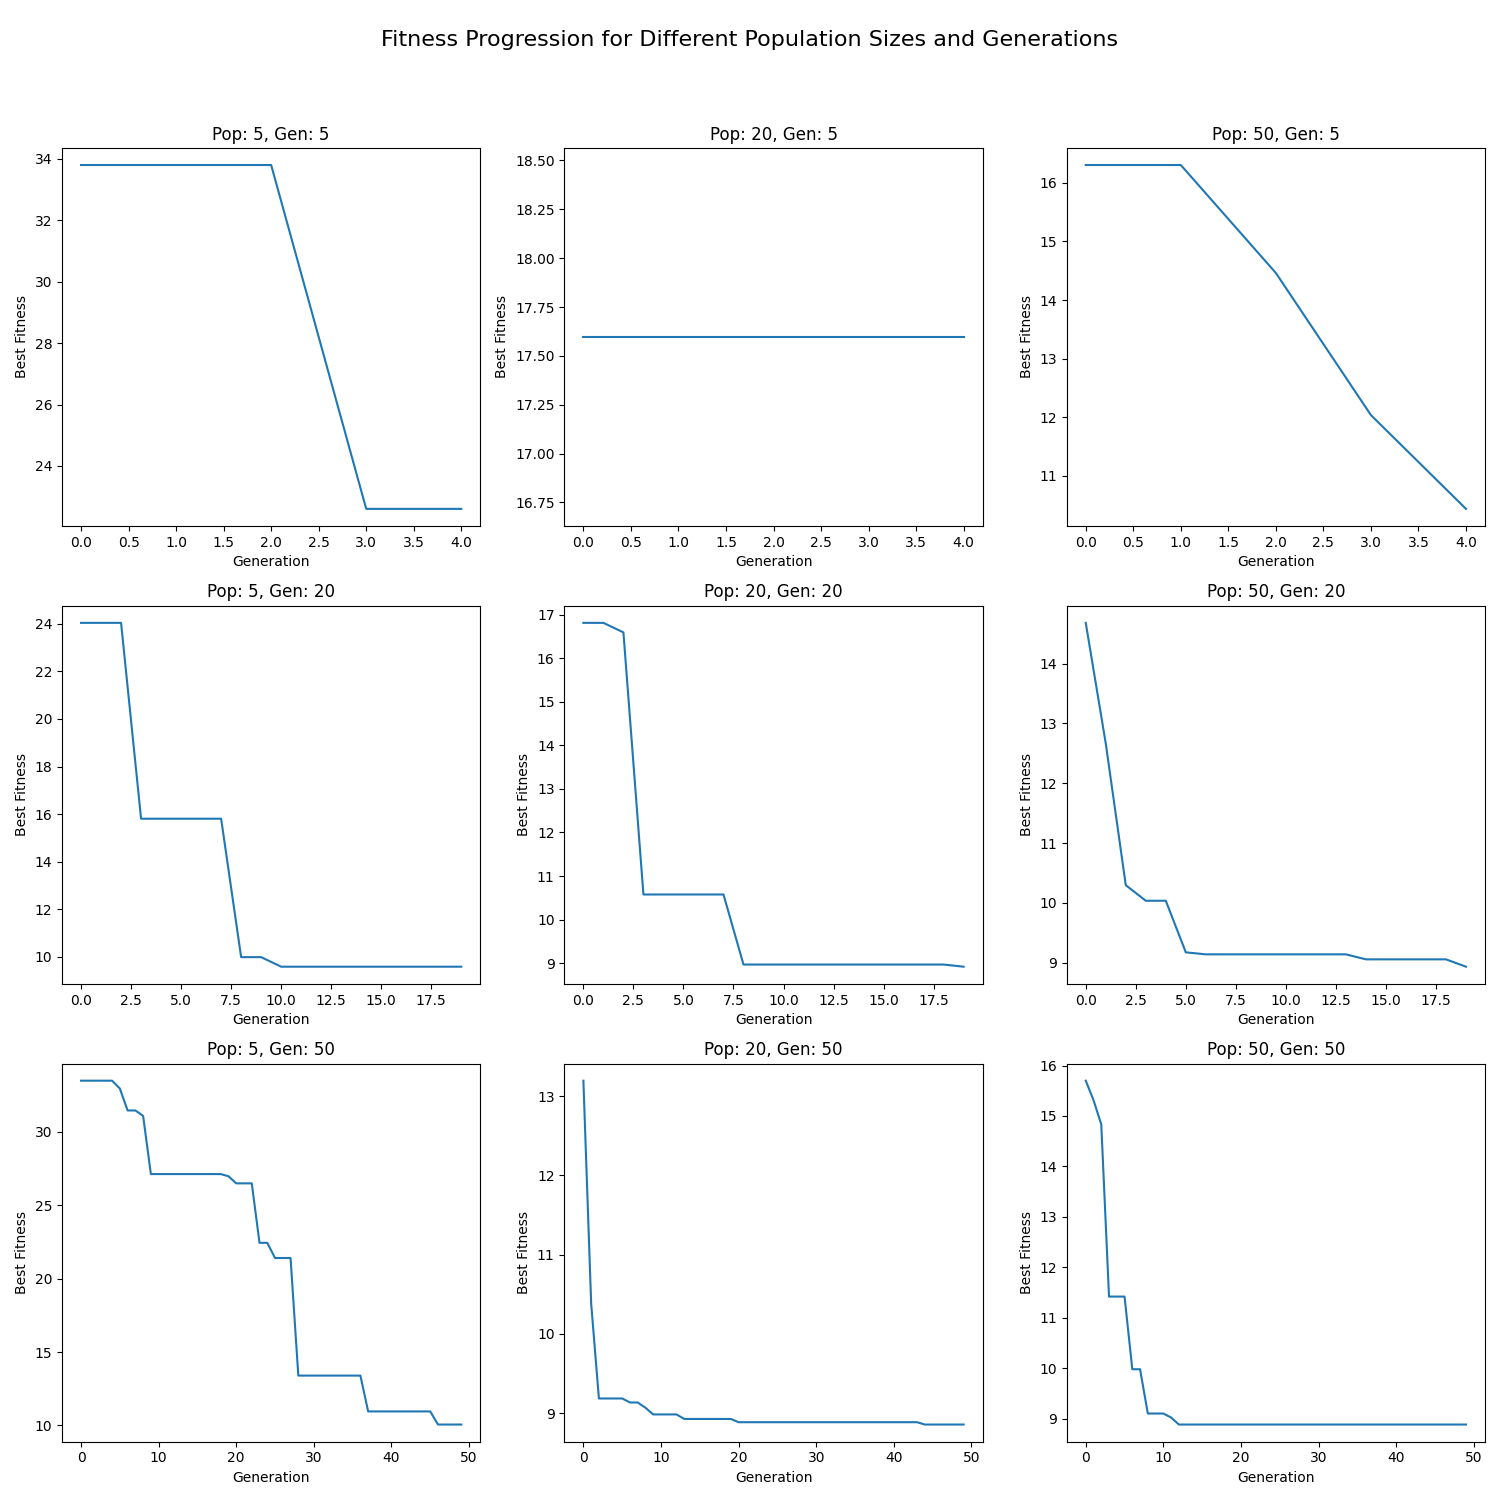

#### Summary of Results
* Larger populations generally lead to better solutions due to greater genetic diversity, which allows the algorithm to explore more of the solution space. However, this also increases computational time significantly.

* Running the algorithm for more generations typically improves the fitness results by allowing more refinement of solutions. However, the relationship isn't perfectly linear, as some configurations reach similar fitness values with fewer generations, particularly for larger populations.

* Lower population sizes and fewer generations are quicker but generally yield poorer solutions. High population sizes and generations provide better solutions but are computationally expensive.

* For a moderate balance between solution quality and computational time, a population size of 20 and around 20–50 generations appears to perform well.

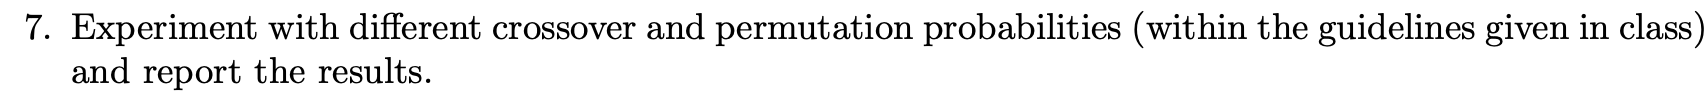

### 1.7 Output

#### Run Data

#### Plots

#### Summary of Results